<font size="18">Image Augmentation APP</font>

This application demonstrates a simple rocAL pipeline with different interpolation types on resize augmentation supported by rocAL.<br>
Illustrated below how to create a pipeline for resize augmentation with different interpolation types, set outputs, build, run the pipeline and enumerate over the results.

<font size="12"> Common Code </font>

In [2]:
from amd.rocal.plugin.generic import ROCALClassificationIterator
from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import amd.rocal.types as types
# from parse_config import parse_args
import os
import cupy as cp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
%matplotlib inline


/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<font size= "12" >Configuring rocAL pipeline </font>

Configure the pipeline parameters as required by the user.

In [3]:
data_path = "/media/MIVisionX-data/rocal_data/coco/coco_10_img/train_10images_2017/"
rocal_cpu = True
device = "cpu"
batch_size = 1
num_threads = 1
random_seed = 1
local_rank = 0
world_size = 1
display = True

In [4]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=local_rank, seed=random_seed, rocal_cpu=rocal_cpu, tensor_layout=types.NHWC ,tensor_dtype=types.FLOAT)


Pipeline has been created succesfullyOK: loaded 113 kernels from libvx_rpp.so



<font size="12"> Image augmentation pipeline </font>

Here we use the file reader followed by the turbo jpeg decoder. In this pipeline we add cascaded augmentation on the decoded image.<br>We enable the output for differnet augmentaion using set_output

In [5]:
resize_w = 200
resize_h = 200
with pipe:
        jpegs, _ = fn.readers.file(file_root=data_path)
        images = fn.decoders.image(jpegs, file_root=data_path, device=0, output_type=types.RGB, shard_id=0, num_shards=1, random_shuffle=False)
        output_linear = fn.resize(images, resize_width=resize_w, resize_height=resize_h, interpolation_type=types.LINEAR_INTERPOLATION)
        output_nearest_neighbor = fn.resize(images, resize_width=resize_w, resize_height=resize_h, interpolation_type=types.NEAREST_NEIGHBOR_INTERPOLATION)
        output_cubic = fn.resize(images, resize_width=resize_w, resize_height=resize_h, interpolation_type=types.CUBIC_INTERPOLATION)
        output_lanczos = fn.resize(images, resize_width=resize_w, resize_height=resize_h, interpolation_type=types.LANCZOS_INTERPOLATION)
        output_gaussian = fn.resize(images, resize_width=resize_w, resize_height=resize_h, interpolation_type=types.GAUSSIAN_INTERPOLATION)
        output_triangular = fn.resize(images, resize_width=resize_w, resize_height=resize_h, interpolation_type=types.TRIANGULAR_INTERPOLATION)
        
        pipe.set_outputs(output_linear, output_nearest_neighbor, output_cubic, output_lanczos, output_gaussian, output_triangular)


In [6]:
pipe.build()
# Dataloader
data_loader = ROCALClassificationIterator(pipe)

<font size ="12">Visualizing  outputs</font>

We have displayed the output of augmented images using imshow()

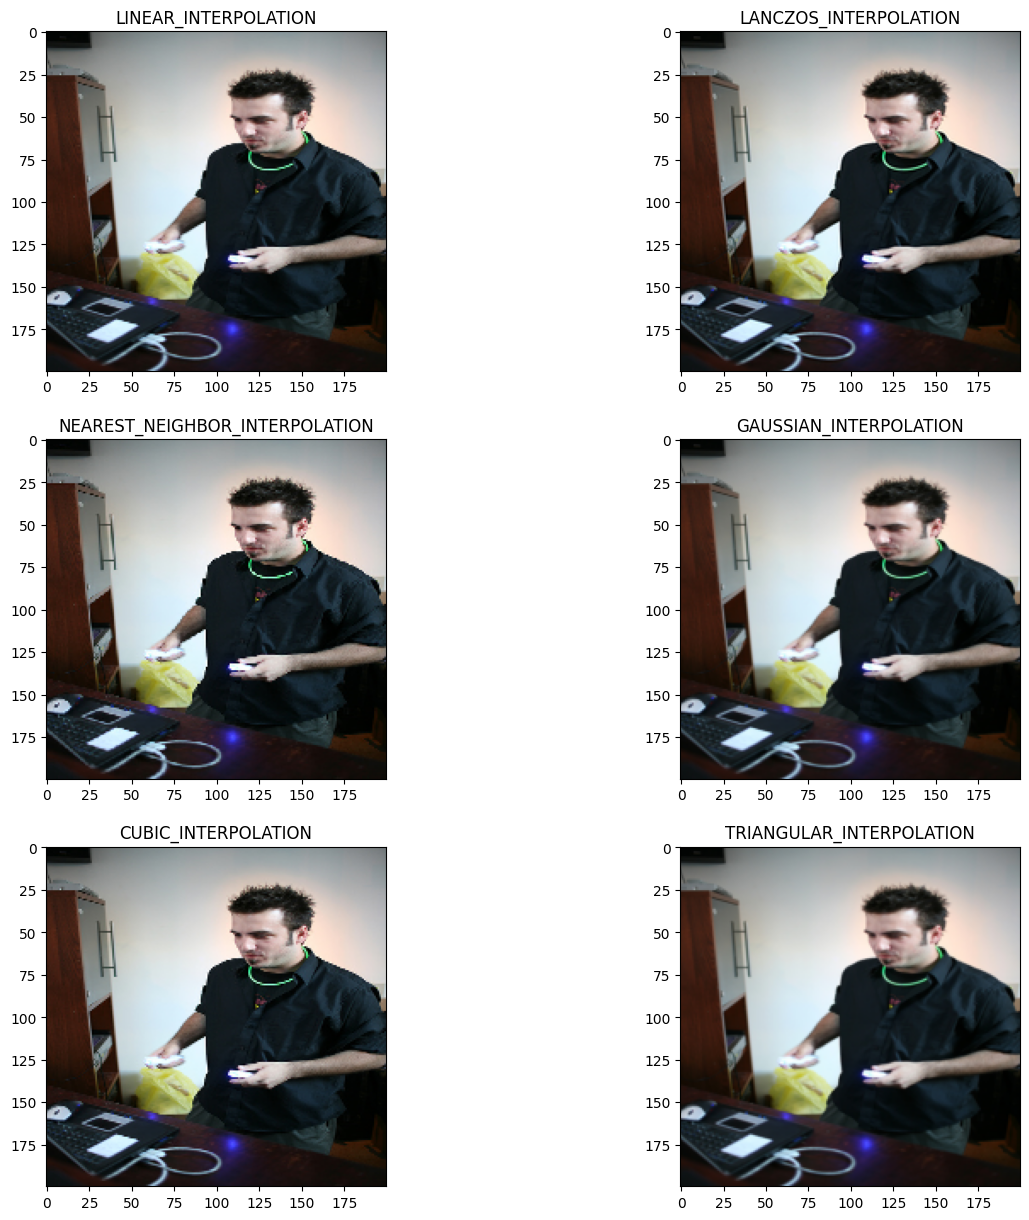

In [7]:
cnt = 0
aug_list = ["LINEAR_INTERPOLATION", "NEAREST_NEIGHBOR_INTERPOLATION", "CUBIC_INTERPOLATION", "LANCZOS_INTERPOLATION", "GAUSSIAN_INTERPOLATION", "TRIANGULAR_INTERPOLATION"] 
row = 0
col = 0
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
for i, it in enumerate(data_loader, 0):
    for img in it[0]:
        if cnt < len(aug_list):
            axes[row, col].set_title(aug_list[cnt])
        img = (img[0]).astype("uint8")
        axes[row, col].imshow(img)
        cnt = cnt + 1
        row += 1
        if row == 3:
            row = 0
            col += 1
        if col == 2:
            col = 0
data_loader.reset()